## CTT模型

In [1]:
import copy
import torch
import math
import numpy as np
import pandas as pd
import geatpy as ea
from tqdm import tqdm
from multiprocessing.dummy import Pool as ThreadPool
from torch import nn
from torch import optim
import torch.nn.functional as F
import matplotlib.pyplot as plt
import utils.calculate_param as cp
from dataset import data_read
from torch.utils.data import TensorDataset
from torch.utils.data import DataLoader
from sklearn.metrics import mean_absolute_error, explained_variance_score, r2_score, mean_squared_error

In [55]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device

device(type='cpu')

In [56]:
X_train, y_train = data_read.load_data('train')
X_test, y_test = data_read.load_data('test')

X_train.shape

(2000, 50)

In [57]:
X_train = torch.from_numpy(X_train).float().to(device) # [len * feature]
y_train = torch.from_numpy(y_train).float().to(device)
X_test = torch.from_numpy(X_test).float().to(device) # [len * feature]
y_test = torch.from_numpy(y_test).float().to(device)

X_train.shape

torch.Size([2000, 50])

In [58]:
train_data_loader = DataLoader(TensorDataset(X_train, y_train), batch_size=100, shuffle=False)
test_data_loader = DataLoader(TensorDataset(X_test, y_test), batch_size=100, shuffle=False)

In [79]:
# CNN
class CNN(nn.Module):
    def __init__(self):
        super(CNN,self).__init__()
        self.conv1 = nn.Sequential(
            nn.Conv2d(in_channels=1, out_channels=3, kernel_size=7),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2)
        )
        self.conv2 = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=6, kernel_size=7),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2)
        )
        self.out=nn.Linear(960, 50)

    def forward(self, x):
        x= self.conv1(x)
        # print(x.shape)
        x= self.conv2(x)
        # print(x.shape)
        x= x.view(-1, x.size(0) * x.size(1) * x.size(2))
        # print(x.shape)
        out = self.out(x)
        return out

# 位置编码类
class PositionalEncoding(nn.Module):
    def __init__(self, d_model, max_len=5000):
        super(PositionalEncoding, self).__init__()
        pe = torch.zeros(max_len, d_model)
        position = torch.arange(0, max_len, dtype=torch.float).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2).float() * (-math.log(10000.0) / d_model))
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        pe = pe.unsqueeze(0).transpose(0, 1)
        self.register_buffer('pe', pe)

    def forward(self, x):
        out = x + self.pe[:x.size(0), :]
        return out

# 教师模型类
class TeacherTransformer(nn.Module):
    def __init__(self):
        super(TeacherTransformer, self).__init__()
        self.cnn = CNN()
        self.d_model = 128  # 词向量维度
        self.embedding_enc = nn.Linear(50, self.d_model)
        self.embedding_dec = nn.Linear(2, self.d_model)
        self.pos_encoding = PositionalEncoding(self.d_model)
        self.Transformer_layer = nn.Transformer(d_model=128, num_encoder_layers=3, num_decoder_layers=3, batch_first=True)
        self.FC_layer = nn.Linear(128, 2)

    def forward(self, src, tgt):
        # rssi进行cnn特征提取
        src = src.unsqueeze(0)
        src = self.cnn(src)
        # print(src.shape)

        # 使用线性层代替embedding
        src = self.embedding_enc(src).unsqueeze(0)
        tgt = self.embedding_dec(tgt).unsqueeze(0)
        src = self.pos_encoding(src)
        out = self.Transformer_layer(src, tgt)
        out = self.FC_layer(out)
        return out



In [80]:
model = TeacherTransformer().to(device)
criterion = nn.MSELoss()
optimizer = optim.SGD(model.parameters(), lr=1e-3, momentum=0.99)

In [81]:
# 输出模型的参数信息
cp.get_summary(model, input_size=None)

torchinfo信息如下：
Layer (type:depth-idx)                                                 Param #
TeacherTransformer                                                     --
├─CNN: 1-1                                                             --
│    └─Sequential: 2-1                                                 --
│    │    └─Conv2d: 3-1                                                150
│    │    └─ReLU: 3-2                                                  --
│    │    └─MaxPool2d: 3-3                                             --
│    └─Sequential: 2-2                                                 --
│    │    └─Conv2d: 3-4                                                888
│    │    └─ReLU: 3-5                                                  --
│    │    └─MaxPool2d: 3-6                                             --
│    └─Linear: 2-3                                                     48,050
├─Linear: 1-2                                                          6,528
├─Linear:

In [70]:
%%time

best_loss = 100000
best_epoch = 0
for epoch in range(100):
    epoch_loss = 0
    for X, y in train_data_loader:  # enc_inputs : [len * feature]->[2000 * 50]
        # print(X.shape)  # [100 * 50]
        # print(y.shape)  # [100 * 50]
        outputs = model(X, y)
        outputs = outputs.squeeze()  # [100 * 2]
        # print(outputs.shape)
        loss = criterion(outputs, y)
        loss_num = loss.item()
        epoch_loss += loss_num
        optimizer.zero_grad()
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), 0.5)
        optimizer.step()

    if epoch_loss < best_loss:
        best_loss = epoch_loss
        best_epoch = epoch
        best_model_wts = copy.deepcopy(model.state_dict())
        torch.save(best_model_wts, './result/cnn_weight.pth')

    print('Epoch:', '%04d' % (epoch + 1), 'loss =', '{:.6f}'.format(epoch_loss))

# 打印最佳的结果
print('best_loss::|',best_loss,'---best_epoch::|',best_epoch)


Epoch: 0001 loss = 144.026774
Epoch: 0002 loss = 48.555862
Epoch: 0003 loss = 47.365445
Epoch: 0004 loss = 40.471405
Epoch: 0005 loss = 39.706557
Epoch: 0006 loss = 34.525169
Epoch: 0007 loss = 26.731574
Epoch: 0008 loss = 17.818293
Epoch: 0009 loss = 9.911003
Epoch: 0010 loss = 9.740151
Epoch: 0011 loss = 8.207179
Epoch: 0012 loss = 7.761693
Epoch: 0013 loss = 7.263524
Epoch: 0014 loss = 5.981133
Epoch: 0015 loss = 5.030740
Epoch: 0016 loss = 4.302530
Epoch: 0017 loss = 3.582561
Epoch: 0018 loss = 3.175193
Epoch: 0019 loss = 2.693963
Epoch: 0020 loss = 2.512721
Epoch: 0021 loss = 2.279676
Epoch: 0022 loss = 2.378457
Epoch: 0023 loss = 2.321902
Epoch: 0024 loss = 2.332634
Epoch: 0025 loss = 1.807863
Epoch: 0026 loss = 2.071731
Epoch: 0027 loss = 2.090234
Epoch: 0028 loss = 2.499338
Epoch: 0029 loss = 2.676956
Epoch: 0030 loss = 1.879897
Epoch: 0031 loss = 1.733085
Epoch: 0032 loss = 1.730593
Epoch: 0033 loss = 1.439644
Epoch: 0034 loss = 1.592946
Epoch: 0035 loss = 1.463387
Epoch: 0036

In [95]:
model = TeacherTransformer().to(device)
# 暂存教师模型为teacher_model
teacher_model = model
model.load_state_dict(torch.load('./result/cnn_weight.pth'))
model.eval()

pxy_all = []
y_all = []
for X, y in test_data_loader:
    pxy = model(X, y)
    pxy = pxy.cpu().detach().numpy().squeeze(0)
    y = y.cpu().detach().numpy()
    pxy_all.append(pxy)
    y_all.append(y)

# 计算指标
pxy_all = np.array(pxy_all).reshape(-1, 2)
y_all = np.array(y_all).reshape(-1, 2)
mae = mean_absolute_error(y_all, pxy_all)
mse = mean_squared_error(y_all, pxy_all)
rmse = mse ** 0.5
evs = explained_variance_score(y_all, pxy_all)
r2 = r2_score(y_all, pxy_all)

mmax = 0
mmin = 10000
for i in range(len(pxy_all)):
    mmax = max(mean_absolute_error(y_all[i], pxy_all[i]), mmax)
    mmin = min(mean_absolute_error(y_all[i], pxy_all[i]), mmin)

print({'mae': mae, 'mse': mse, 'rmse': rmse, 'evs': evs, 'r2': r2, 'mmax': mmax, 'mmin': mmin})

y_teacher = y_all[:20]
pxy = pxy_all[:20]
coor1 = pd.DataFrame(y_teacher)
coor1.columns = ['X', 'y']

coor2 = pd.DataFrame(pxy)
coor2.columns = ['PX', 'Py']

coor = pd.concat([coor1, coor2], axis=1)
coor.to_csv('./result/coordinate_all_cnn.csv')
print(coor)

{'mae': 0.14421527, 'mse': 0.034506127, 'rmse': 0.1857582494487758, 'evs': 0.9924837350845337, 'r2': 0.9833298001558972, 'mmax': 0.41511703, 'mmin': 0.0030628443}
       X     y        PX        Py
0   0.21  3.47  0.163818  3.608673
1   1.13  1.96  1.152956  1.988453
2   3.38  2.58  3.411692  2.642722
3   4.07  2.72  4.307161  2.855770
4   1.58  2.47  1.606111  2.486304
5   3.43  1.61  3.513378  1.662431
6   1.22  0.74  1.197480  0.739431
7   2.33  1.97  2.297016  2.020132
8   0.33  3.56  0.278251  3.719915
9   3.53  4.28  3.785691  4.641196
10  4.42  3.69  4.771204  3.983682
11  3.67  0.34  3.864224  0.277744
12  2.57  0.37  2.624993  0.388600
13  3.14  3.22  3.205686  3.290687
14  4.76  3.34  5.058994  3.540279
15  1.70  3.71  1.698522  3.835127
16  3.50  1.20  3.660272  1.212354
17  0.68  4.65  0.654991  4.754219
18  1.09  4.59  1.051207  4.763106
19  0.25  3.70  0.206386  3.857233


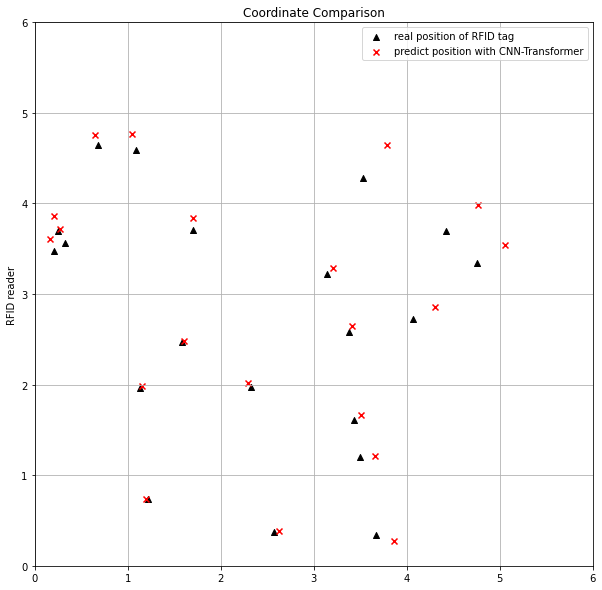

In [101]:
plt.figure(figsize=[10, 10])
plt.xlim((0, 6))
plt.ylim((0, 6))
plt.ylabel('RFID reader')
plt.title('Coordinate Comparison')
# 画图-标准坐标
plt.scatter(y_teacher[:, 0], y_teacher[:, 1], c='black', marker='^', label='real position of RFID tag')

# 画图-预测EA坐标
plt.scatter(pxy[:, 0], pxy[:, 1], c='red', marker='x', label = 'predict position with CNN-Transformer')

plt.legend()
plt.grid('True')
plt.savefig('./result/compare_coordinate_cnn.jpg', dpi=750, bbox_inches = 'tight')